In [ ]:
import numpy as np
from scipy.optimize import minimize, dual_annealing
import cma
import pandas as pd
import matplotlib.pyplot as plt
import time

Problem 2. (Derivative-Free Optimization Methods). This assignment explores Nelder-Mead, Sim-
ulated Annealing, and Covariance Matrix Adaptation Evolution Strategy (CMA-ES). 

You willimplement these optimization techniques and compare their performance on different objective functions.
Implement or use available libraries to apply the following optimization techniques:

• Nelder-Mead (Simplex Method)

• Simulated Annealing

• CMA-ES (Covariance Matrix Adaptation Evolution Strategy)

Ensure that each method is applied with appropriate hyperparameters.

### Task 1: Benchmarking on Test Functions (1 mark)

In [29]:
def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rastrigin(x):
    return 10 * len(x) + sum(x_i**2 - 10 * np.cos(2 * np.pi * x_i) for x_i in x)

def ackley(x):
    sum_sq = sum(x_i**2 for x_i in x) / len(x)
    sum_cos = sum(np.cos(2 * np.pi * x_i) for x_i in x) / len(x)
    
    return -20 * np.exp(-0.2 * np.sqrt(sum_sq)) - np.exp(sum_cos) + 20 + np.e

In [ ]:
def opt_nelder(loss, init, bounds=None):
    result = minimize(loss, init, method='Nelder-Mead', bounds=bounds, options={'maxiter': 1000, 'disp': False})
    return result

def opt_annealing(loss, bounds, iterations=1000):
    result = dual_annealing(loss, bounds=bounds, maxiter=iterations)
    return result

def opt_cov(loss, init, sigma=0.5, iterations=1000, bounds=None):
    opts = cma.CMAOptions()
    if bounds is not None:
        lower_bounds = []
        upper_bounds = []
        
        for a, b in bounds:
            lower_bounds.append(a)
            upper_bounds.append(b)

        opts.set('bounds', [lower_bounds, upper_bounds])
    opts['maxiter'] = iterations
    
    es = cma.CMAEvolutionStrategy(init, sigma, opts)
    es.optimize(loss)
    
    result = {
        'x': es.result.xbest,
        'fun': es.result.fbest,
        'nfev': es.result.evaluations,
        'success': es.stop() != [],
        'message': str(es.stop())
    }

    return result


In [ ]:
def benchmark_optims(functions, dimensions, bounds, optimizers, runs=5):
    results = []
    for func_name, func in functions.items():
        dim, func_bounds = dimensions[func_name], bounds[func_name]
        print(f"Benchmarking {func_name} function with dimension {dim}")
        print(f"  Function bounds: {func_bounds}")
        
        for optm, optimizer in optimizers.items():
            print(f"  Using {optm} optimizer")
            
            for run in range(runs):
                print(f"    Run {run+1}/{runs}")
                
                init_guess = None if optm == 'Simulated Annealing' else np.random.uniform(*zip(*func_bounds), size=dim)
                
                start_time = time.time()
                
                if optm == 'Nelder-Mead':
                    result = optimizer(func, init_guess, func_bounds)
                elif optm == 'Simulated Annealing':
                    result = optimizer(func, func_bounds)
                else:
                    result = optimizer(func, init_guess, bounds=func_bounds)
                    result = {**result, 'x': result['x'], 'fun': result['fun']}
                
                elapsed_time = time.time() - start_time
                
                results.append({
                    'Function': func_name,
                    'Optimizer': optm,
                    'Run': run + 1,
                    'Best Value': result['fun'],
                    'Best Position': result['x'],
                    'Success': result['success'],
                    'Function Evaluations': result['nfev'],
                    'Time (s)': elapsed_time
                })
    return pd.DataFrame(results)


Benchmarking Rosenbrock function with dimension 10
  Function bounds: [(-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10)]
  Using Nelder-Mead optimizer
    Run 1/10
    Run 2/10
    Run 3/10
    Run 4/10
    Run 5/10
    Run 6/10
    Run 7/10
    Run 8/10
    Run 9/10
    Run 10/10
  Using Simulated Annealing optimizer
    Run 1/10
    Run 2/10
    Run 3/10
    Run 4/10
    Run 5/10
    Run 6/10
    Run 7/10
    Run 8/10
    Run 9/10
    Run 10/10
  Using CMA-ES optimizer
    Run 1/10
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=414444, Sun Mar 30 23:11:50 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.324624616135907e+03 1.0e+00 4.80e-01  5e-01  5e-01 0:00.0
    2     20 2.214937622778992e+03 1.2e+00 4.85e-01  5e-01  5e-01 0:00.0
    3     30 6.920374012478363e+02 1.3e+00 5.39e-01  5e-01  6e-01 0:00.0
  100   1000 4.637018624414641e-02 3.3e+01 6.33e-01  2e-01  1e+00 0:00.1
  200

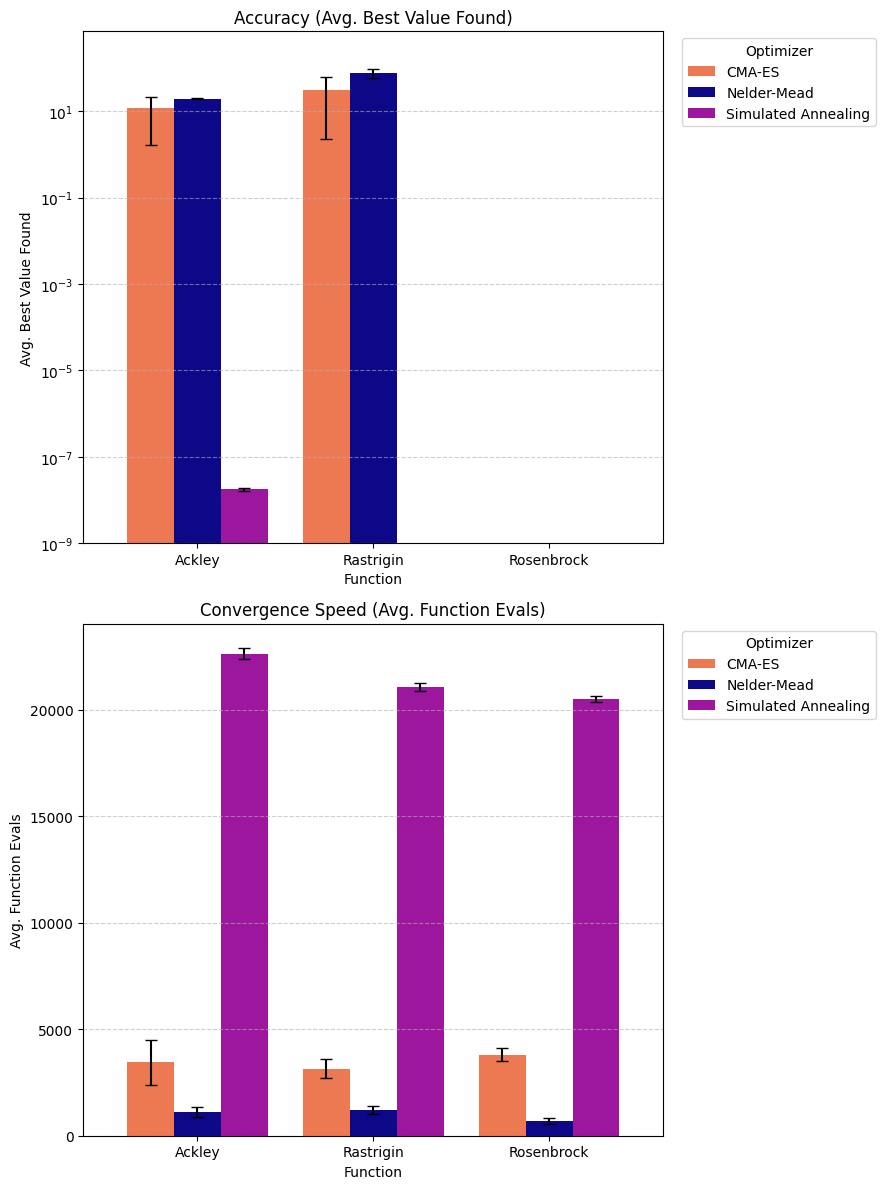

In [ ]:
def analyze_results(results_df):
    summary = results_df.groupby(['Function', 'Optimizer']).agg(
        Mean_Best_Value=('Best Value', 'mean'),
        Std_Best_Value=('Best Value', 'std'),
        Mean_Function_Evals=('Function Evaluations', 'mean'),
        Std_Function_Evals=('Function Evaluations', 'std')
    ).reset_index()
    
    print(summary.to_string(index=False))

def plot_results(results_df):
    functions = results_df['Function'].unique()
    optimizers = results_df['Optimizer'].unique()
    n_funcs = len(functions)
    n_opts = len(optimizers)

    metrics_to_plot = {
        'Best Value': 'Accuracy (Avg. Best Value Found)',
        'Function Evaluations': 'Convergence Speed (Avg. Function Evals)'
    }

    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(max(10, n_funcs * n_opts * 0.5), 12), squeeze=False)
    axes = axes.flatten()

    color_map = plt.get_cmap('plasma')
    opt_colors = {opt: color_map(i/n_opts) for i, opt in enumerate(optimizers)}

    grouped = results_df.groupby(['Function', 'Optimizer'])

    for i, (metric, title_label) in enumerate(metrics_to_plot.items()):
        ax = axes[i]
        mean_metric = grouped[metric].mean().unstack()
        std_metric = grouped[metric].std().unstack()

        mean_metric.plot(kind='bar', yerr=std_metric, ax=ax, capsize=4, color=[opt_colors[opt] for opt in mean_metric.columns],
                         width=0.8)

        ax.set_ylabel(title_label.split('(')[1].replace(')', '')) 
        ax.set_xlabel("Function")
        ax.set_title(title_label) 
        ax.tick_params(axis='x', rotation=0) 
        ax.grid(True, linestyle='--', alpha=0.6, axis='y')

        if i == 0:  # Apply log scale for the first plot
            ax.set_yscale('log')
            current_ylim = ax.get_ylim()
            ax.set_ylim(bottom=max(1e-9, current_ylim[0]))

        ax.legend(title='Optimizer', bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout(rect=[0, 0, 0.9, 1]) 
    plt.show()

functions = {'Rosenbrock': rosenbrock, 'Rastrigin': rastrigin, 'Ackley': ackley}
DIM = 10
bounds = {
    'Rosenbrock': [(-5, 10)] * DIM,
    'Rastrigin': [(-5.12, 5.12)] * DIM,
    'Ackley': [(-32.768, 32.768)] * DIM
}
optimizers = {
    'Nelder-Mead': opt_nelder,
    'Simulated Annealing': opt_annealing,
    'CMA-ES': opt_cov
}

dimensions = {func: DIM for func in functions}

results_df = benchmark_optims(functions, dimensions, bounds, optimizers, runs=10)
analyze_results(results_df)
plot_results(results_df)

## Observations

1. Ackley Function

Accuracy:
Simulated Annealing achieved an almost perfect result (mean best value ≈ 1.79×10⁻⁸), while CMA-ES and Nelder-Mead converged to significantly higher values (11.67 and 19.55, respectively).

Convergence Speed:
Simulated Annealing required a very high number of function evaluations (mean = 22,621), compared to roughly 1,115 evaluations for Nelder-Mead and 3,447 for CMA-ES.

Conclusion:
Simulated Annealing delivers the best accuracy for the Ackley function but at a considerable computational cost. Nelder-Mead is much faster but may get stuck in poor local optima.

2. Rastrigin Function

Accuracy:
Simulated Annealing again shows best convergence (mean best value ≈ 7.39×10⁻¹⁴, nearly zero), while CMA-ES convergence is not that great (≈ 31.94) and Nelder-Mead performs worst (≈ 78.93).

Convergence Speed:
Simulated Annealing used around 21,061 evaluations on average, whereas Nelder-Mead and CMA-ES required about 1,206 and 3,154 evaluations, respectively.

Conclusion:
For the Rastrigin function, Simulated Annealing is the most robust in finding the global optimum, though it is much slower. Nelder-Mead, while fast, is not well-suited to navigating the numerous local minima in this function.

3. Rosenbrock Function

Accuracy:
All methods converge very close to the global optimum. CMA-ES achieved the lowest mean best value (≈ 3.44×10⁻¹⁵), followed by Simulated Annealing (≈ 2.17×10⁻¹¹) and Nelder-Mead (≈ 2.30×10⁻¹⁰).

Convergence Speed:
Nelder-Mead is the most efficient here (mean evaluations ≈ 686), with CMA-ES and Simulated Annealing requiring about 3,807 and 20,508 evaluations, respectively.

Conclusion:
On the smoother Rosenbrock function, Nelder-Mead’s speed is a significant advantage, even though all methods achieve near-optimal results. CMA-ES obtains slightly better accuracy but at a higher computational cost, while Simulated Annealing is the slowest.

Overall Trade-offs
Nelder-Mead:

Pros: Fast convergence (fewer evaluations) especially on smooth functions like Rosenbrock.

Cons: Can be unreliable on complex, functions such as Ackley and Rastrigin, leading to poor accuracy in some runs.
Simulated Annealing:

Pros: Robust and consistent, always converging to near-optimal solutions even on difficult landscapes.

Cons: Extremely high computational cost (many evaluations) for high-dimensional problems.

CMA-ES:

Pros: Balances reliability and accuracy, particularly effective for complex functions like Ackley and Rastrigin.

Cons: Moderate to high evaluation counts mean it’s slower than Nelder-Mead, although faster than Simulated Annealing on average.


## Task 2: Hyperparameter Tuning in Machine Learning (2 marks)

In [83]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize, dual_annealing
import warnings
warnings.filterwarnings('ignore')

try:
    import cma
    CMA_AVAILABLE = True
except ImportError:
    CMA_AVAILABLE = False
    print("CMA package not found.")

def load_mnist_data(n_samples=5000):
    print("Loading MNIST dataset...")    
    digits = datasets.load_digits()
    if n_samples > len(digits.data):
        n_samples = len(digits.data)
    
    indices = np.random.choice(len(digits.data), n_samples, replace=False)
    X = digits.data[indices]
    y = digits.target[indices]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    print(f"Dataset prepared: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")
    
    return X_train, X_test, y_train, y_test


def evaluate_svm_hyperparameters(params, X_train, X_test, y_train, y_test, param_space):
    C = 10 ** (params[0] * (param_space['C_max'] - param_space['C_min']) + param_space['C_min'])
    gamma = 10 ** (params[1] * (param_space['gamma_max'] - param_space['gamma_min']) + param_space['gamma_min'])
    
    if params[2] < 0.33:
        kernel = 'linear'
    elif params[2] < 0.66:
        kernel = 'rbf'
    else:
        kernel = 'poly'
    
    try:
        model = svm.SVC(C=C, gamma=gamma, kernel=kernel, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        
        return -accuracy  
    except Exception as e:
        print(f"Error with parameters {params}: {str(e)}")
        return 0.0  



def tune_hyperparameters(X_train, X_test, y_train, y_test, optimizers, num_runs=5, max_iter=50):
    results = []
    param_space = {
        'C_min': -3,  
        'C_max': 3,   
        'gamma_min': -5,  
        'gamma_max': 0,   
    }
    
    bounds = [(0, 1), (0, 1), (0, 1)]  
    
    for opt_name, optimizer in optimizers.items():
        print(f"\nTuning hyperparameters using {opt_name}...")
        
        for run in range(num_runs):
            print(f"  Run {run+1}/{num_runs}...")
            
            def objective(params):
                return evaluate_svm_hyperparameters(params, X_train, X_test, y_train, y_test, param_space)
            
            if opt_name == 'Simulated Annealing':
                initial_guess = None
            else:
                initial_guess = np.random.uniform(0, 1, size=3)
            
            start_time = time.time()
            
            if opt_name == 'Nelder-Mead':
                result = optimizer(objective, initial_guess, bounds=bounds, max_iter=max_iter)
                params = result.x
                n_evals = result.nfev
                success = result.success
            elif opt_name == 'Simulated Annealing':
                result = optimizer(objective, bounds=bounds, max_iter=max_iter)
                params = result.x
                n_evals = result.nfev
                success = result.success
            elif opt_name == 'CMA-ES':
                result = optimizer(objective, initial_guess, bounds=bounds, max_iter=max_iter)
                params = result['x']
                n_evals = result['nfev']
                success = result['success']
            
            elapsed_time = time.time() - start_time
            
            C = 10 ** (params[0] * (param_space['C_max'] - param_space['C_min']) + param_space['C_min'])
            gamma = 10 ** (params[1] * (param_space['gamma_max'] - param_space['gamma_min']) + param_space['gamma_min'])
            
            if params[2] < 0.33:
                kernel = 'linear'
            elif params[2] < 0.66:
                kernel = 'rbf'
            else:
                kernel = 'poly'
            
            model = svm.SVC(C=C, gamma=gamma, kernel=kernel, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = metrics.accuracy_score(y_test, y_pred)
            
            results.append({
                'Optimizer': opt_name,
                'Run': run + 1,
                'C': C,
                'gamma': gamma,
                'kernel': kernel,
                'Accuracy': accuracy,
                'Function Evaluations': n_evals,
                'Time (s)': elapsed_time,
                'Success': success
            })
            
            print(f"    Params: C={C:.6f}, gamma={gamma:.6f}, kernel={kernel}")
            print(f"    Accuracy: {accuracy:.6f}, Evaluations: {n_evals}")
    
    return pd.DataFrame(results)

def summarize_performance(df):
    # Compute aggregated performance metrics by optimizer
    perf_stats = df.groupby('Optimizer').agg({
        'Accuracy': ['mean', 'std', 'max'],
        'Function Evaluations': ['mean', 'std'],
        'Time (s)': ['mean', 'std']
    })
    print("\n=== Overall Performance Summary ===")
    print(perf_stats)
    
    print("\n=== Top Performing Runs ===")
    for optimizer in df['Optimizer'].unique():
        opt_data = df[df['Optimizer'] == optimizer]
        best_index = opt_data['Accuracy'].idxmax()
        best_entry = opt_data.loc[best_index]
        print(f"\n{optimizer} best result:")
        print(f"  Accuracy: {best_entry['Accuracy']:.6f}")
        print(f"  Hyperparameters: C = {best_entry['C']:.6f}, gamma = {best_entry['gamma']:.6f}, kernel = {best_entry['kernel']}")
        print(f"  Evaluations: {best_entry['Function Evaluations']}")
        print(f"  Elapsed Time: {best_entry['Time (s)']:.2f} seconds")
    
    print("\n=== Stability Metrics ===")
    for optimizer in df['Optimizer'].unique():
        opt_data = df[df['Optimizer'] == optimizer]
        std_accuracy = opt_data['Accuracy'].std()
        print(f"{optimizer}: Accuracy standard deviation = {std_accuracy:.6f}")
    
    print("\n=== Efficiency Metrics ===")
    for optimizer in df['Optimizer'].unique():
        opt_data = df[df['Optimizer'] == optimizer]
        mean_evals = opt_data['Function Evaluations'].mean()
        mean_time = opt_data['Time (s)'].mean()
        print(f"{optimizer}:")
        print(f"  Average evaluations: {mean_evals:.1f}")
        print(f"  Average time: {mean_time:.2f} seconds")


def visualize_results(df):
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    
    # Plot accuracy over runs for each optimizer
    ax1 = axs[0, 0]
    for optimizer in df['Optimizer'].unique():
        subset = df[df['Optimizer'] == optimizer]
        ax1.scatter(subset['Run'], subset['Accuracy'], label=optimizer, alpha=0.7)
    ax1.set_xlabel('Run')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Test Accuracy by Run and Optimizer')
    ax1.grid(linestyle='--', alpha=0.7)
    ax1.legend()
    
    # Boxplot of accuracy distribution per optimizer
    ax2 = axs[0, 1]
    acc_data = [df[df['Optimizer'] == opt]['Accuracy'] for opt in df['Optimizer'].unique()]
    ax2.boxplot(acc_data, labels=df['Optimizer'].unique())
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Distribution per Optimizer')
    ax2.grid(linestyle='--', alpha=0.7)
    
    # Plot function evaluations per run
    ax3 = axs[1, 0]
    for optimizer in df['Optimizer'].unique():
        subset = df[df['Optimizer'] == optimizer]
        ax3.scatter(subset['Run'], subset['Function Evaluations'], label=optimizer, alpha=0.7)
    ax3.set_xlabel('Run')
    ax3.set_ylabel('Function Evaluations')
    ax3.set_title('Evaluations per Run')
    ax3.grid(linestyle='--', alpha=0.7)
    ax3.legend()
    
    # Plot hyperparameter exploration: C vs gamma
    ax4 = axs[1, 1]
    for optimizer in df['Optimizer'].unique():
        subset = df[df['Optimizer'] == optimizer]
        ax4.scatter(subset['C'], subset['gamma'], label=optimizer, alpha=0.7, s=100)
    ax4.set_xlabel('C (log scale)')
    ax4.set_ylabel('gamma (log scale)')
    ax4.set_title('Hyperparameter Exploration')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.grid(linestyle='--', alpha=0.7)
    ax4.legend()
    
    plt.tight_layout()
    
    # Create an additional plot for kernel type selection percentages
    plt.figure(figsize=(10, 6))
    kernel_freq = pd.crosstab(df['Optimizer'], df['kernel'])
    kernel_pct = kernel_freq.div(kernel_freq.sum(axis=1), axis=0) * 100
    kernel_pct.plot(kind='bar', stacked=True)
    plt.xlabel('Optimizer')
    plt.ylabel('Percentage')
    plt.title('Kernel Selection Breakdown')
    plt.legend(title='Kernel Type')
    plt.tight_layout()
    plt.savefig('kernel_selection.png', dpi=300)
    print("Kernel selection plot saved as 'kernel_selection.png'")


X_train, X_test, y_train, y_test = load_mnist_data(n_samples=1000)  

optimizers = {
    'Nelder-Mead': opt_nelder,
    'Simulated Annealing': opt_annealing,
}

if CMA_AVAILABLE:
    optimizers['CMA-ES'] = opt_cov

results = tune_hyperparameters(
    X_train, X_test, y_train, y_test, 
    optimizers, 
    num_runs=5,
    max_iter=30  
)



Loading MNIST dataset...
Dataset prepared: 800 training samples, 200 test samples

Tuning hyperparameters using Nelder-Mead...
  Run 1/5...
    Params: C=1.751551, gamma=0.018983, kernel=rbf
    Accuracy: 0.985000, Evaluations: 70
  Run 2/5...
    Params: C=0.119202, gamma=0.000508, kernel=rbf
    Accuracy: 0.110000, Evaluations: 44
  Run 3/5...
    Params: C=21.022397, gamma=0.000115, kernel=poly
    Accuracy: 0.110000, Evaluations: 49
  Run 4/5...
    Params: C=32.118077, gamma=0.028474, kernel=rbf
    Accuracy: 0.980000, Evaluations: 58
  Run 5/5...
    Params: C=0.314382, gamma=0.056463, kernel=poly
    Accuracy: 0.970000, Evaluations: 49

Tuning hyperparameters using Simulated Annealing...
  Run 1/5...
    Params: C=20.671825, gamma=0.000934, kernel=rbf
    Accuracy: 0.985000, Evaluations: 189
  Run 2/5...
    Params: C=2.076923, gamma=0.005453, kernel=rbf
    Accuracy: 0.985000, Evaluations: 197
  Run 3/5...
    Params: C=1.812379, gamma=0.010754, kernel=rbf
    Accuracy: 0.98000


=== Overall Performance Summary ===
                    Accuracy                  Function Evaluations             \
                        mean       std    max                 mean        std   
Optimizer                                                                       
CMA-ES                 0.984  0.006519  0.990                155.4  78.011538   
Nelder-Mead            0.631  0.475636  0.985                 54.0  10.271319   
Simulated Annealing    0.984  0.002236  0.985                190.6   4.560702   

                     Time (s)            
                         mean       std  
Optimizer                                
CMA-ES               2.696723  1.249905  
Nelder-Mead          1.392556  0.294013  
Simulated Annealing  4.004929  0.201508  

=== Top Performing Runs ===

Nelder-Mead best result:
  Accuracy: 0.985000
  Hyperparameters: C = 1.751551, gamma = 0.018983, kernel = rbf
  Evaluations: 70
  Elapsed Time: 1.57 seconds

Simulated Annealing best result:
  A

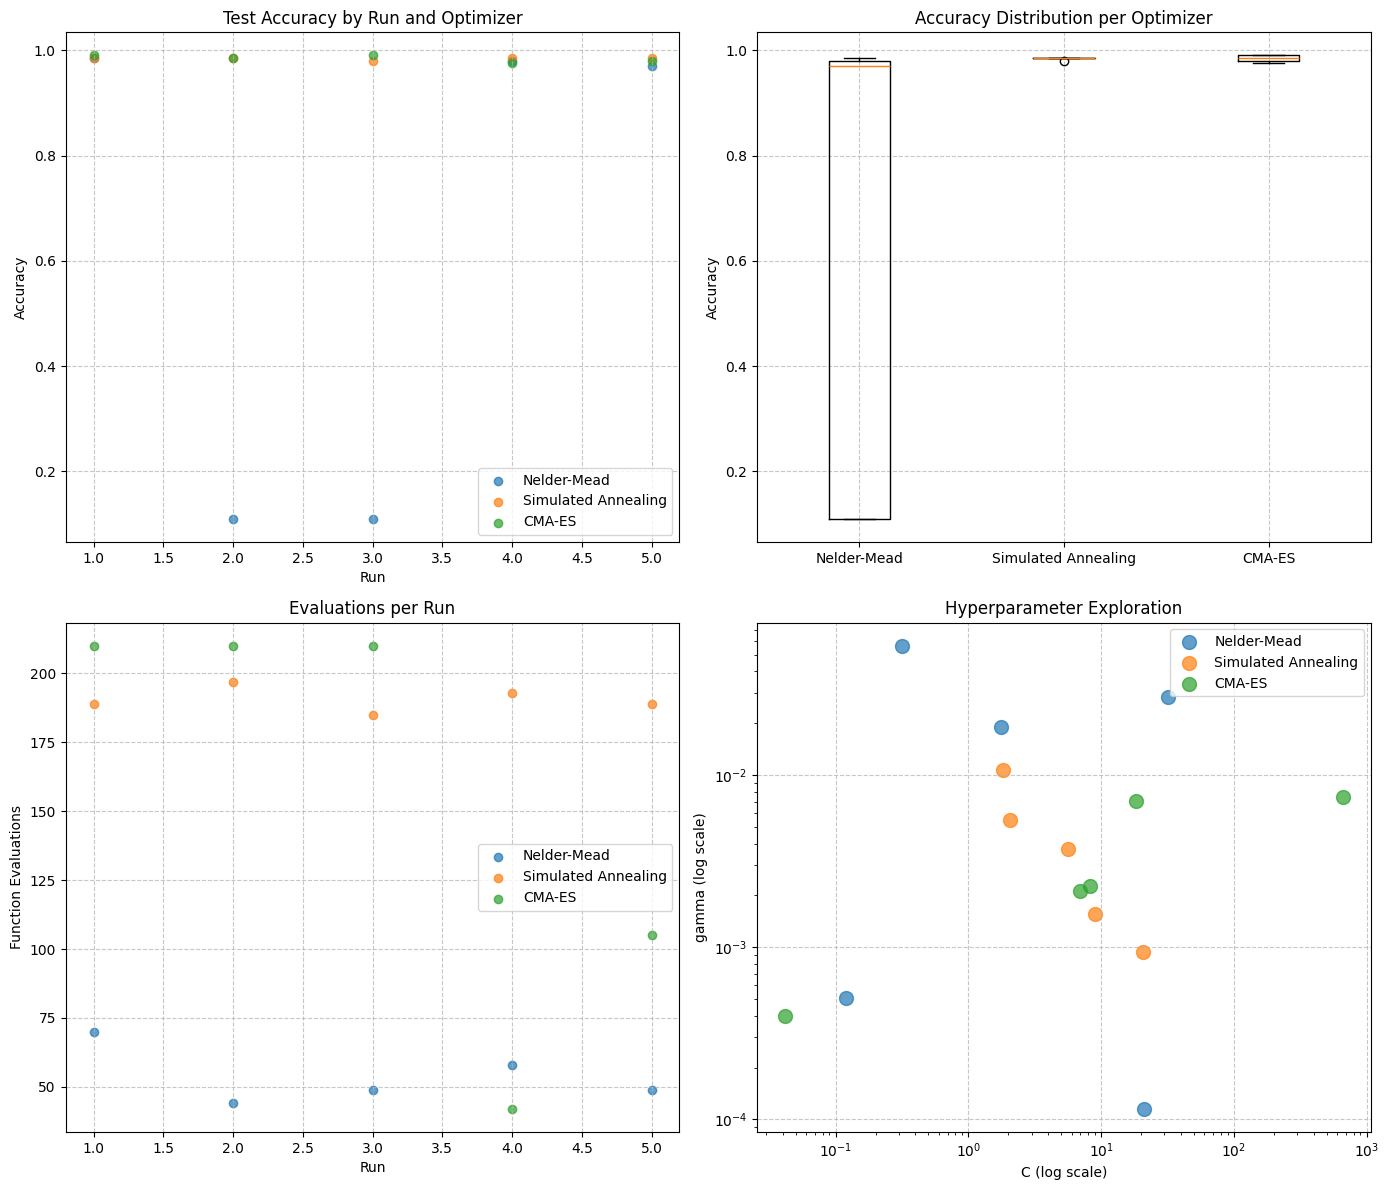

<Figure size 1000x600 with 0 Axes>

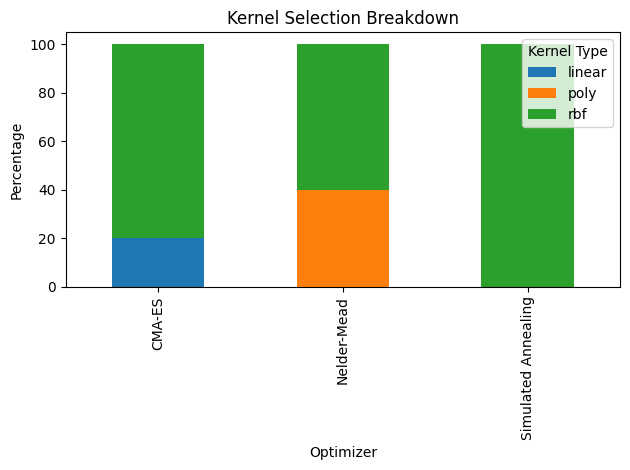

In [85]:
summarize_performance(results)
visualize_results(results)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=510716, Mon Mar 31 00:35:56 2025)


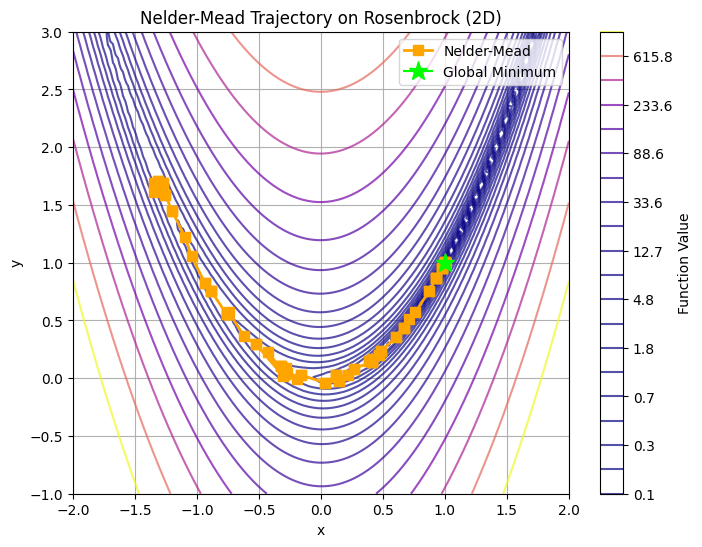

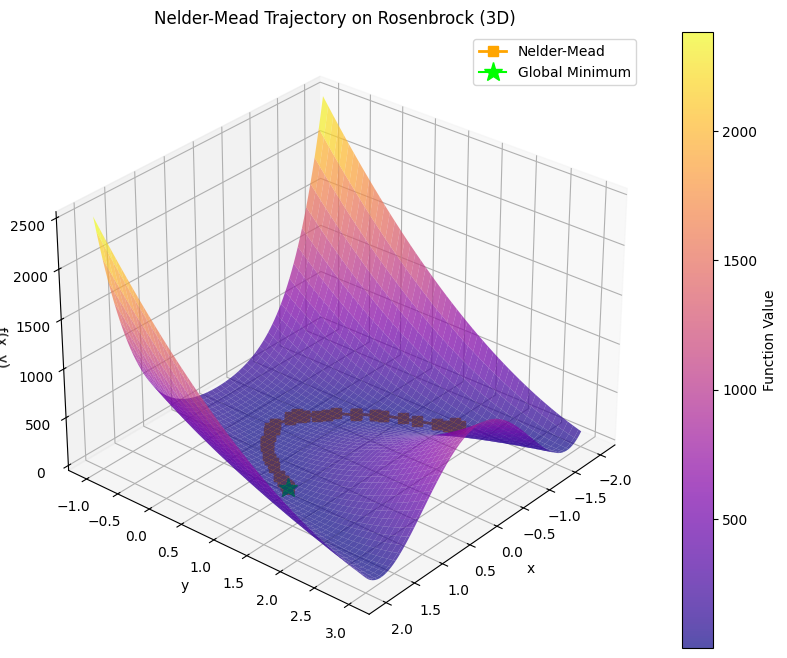

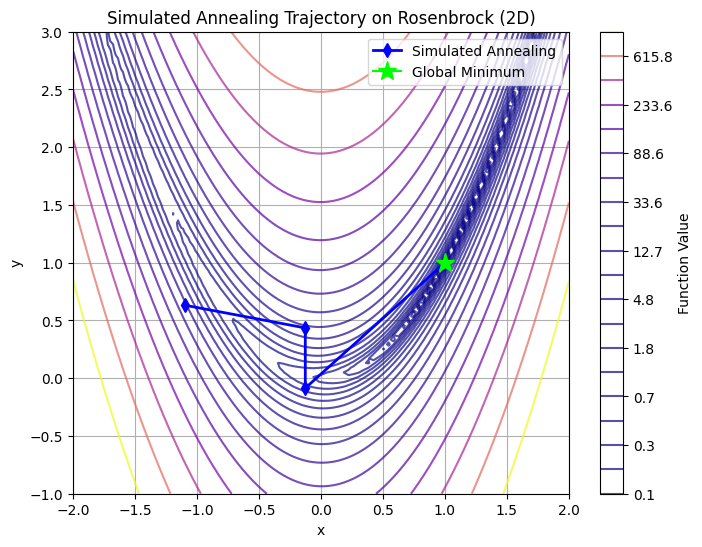

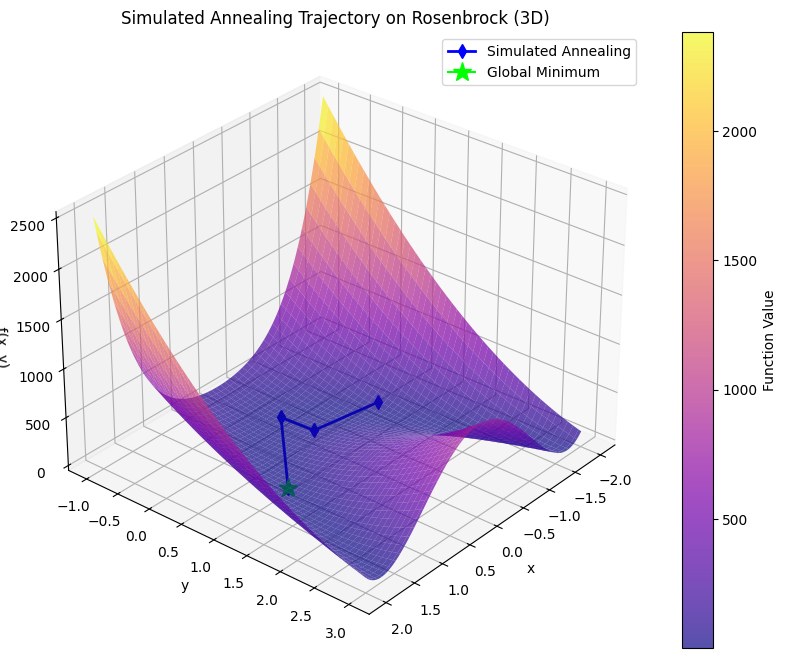

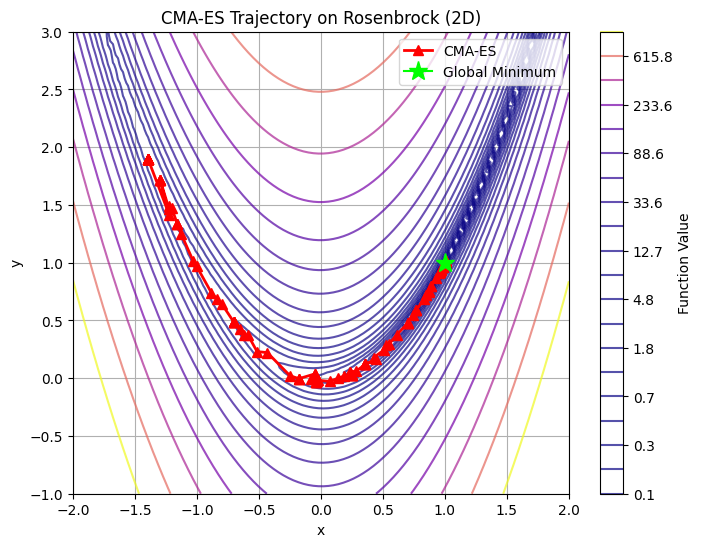

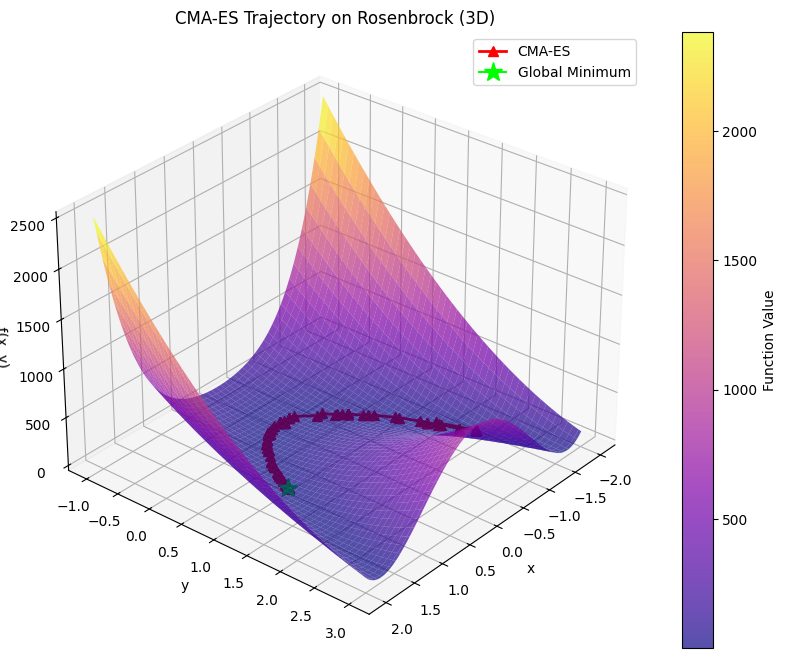

In [86]:
# Define meshgrid for visualization
x_vals = np.linspace(-2, 2, 100)
y_vals = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosenbrock([X, Y])

def visualize_trajectory(x_hist, y_hist, method_name, line_color, marker_style):
    z_hist = [rosenbrock([x, y]) for x, y in zip(x_hist, y_hist)]
    
    # 2D Contour Plot
    plt.figure(figsize=(8, 6))
    plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='plasma', alpha=0.7)
    plt.colorbar(label='Function Value')
    
    plt.plot(x_hist, y_hist, linestyle='-', marker=marker_style, color=line_color, markersize=7, linewidth=2, label=method_name)
    plt.plot(1, 1, marker='*', color='lime', markersize=14, label='Global Minimum')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'{method_name} Trajectory on Rosenbrock (2D)')
    plt.legend()
    plt.grid()
    plt.show()
    
    # 3D Surface Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.plasma, alpha=0.7, edgecolor='none')
    fig.colorbar(surf, ax=ax, label='Function Value')
    
    ax.plot(x_hist, y_hist, z_hist, linestyle='-', marker=marker_style, color=line_color, markersize=7, linewidth=2, label=method_name)
    ax.plot([1], [1], [0], marker='*', color='lime', markersize=14, label='Global Minimum')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')
    ax.set_title(f'{method_name} Trajectory on Rosenbrock (3D)')
    ax.view_init(elev=30, azim=40)
    ax.legend()
    plt.show()

# Optimization trajectory storage
nelder_mead_history, annealing_history, cmaes_history = [], [], []

# Nelder-Mead Optimization
res_nm = minimize(rosenbrock, x0=[-1.5, 1.5], method='Nelder-Mead', callback=lambda x: nelder_mead_history.append(x.copy()))
nm_x, nm_y = zip(*nelder_mead_history)

# Simulated Annealing Optimization
res_sa = dual_annealing(rosenbrock, bounds=[(-2, 2), (-1, 3)], callback=lambda x, f, ctx: annealing_history.append(x.copy()))
sa_x, sa_y = zip(*annealing_history)

# CMA-ES Optimization
es = cma.CMAEvolutionStrategy([-1.5, 1.5], 0.5)
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [rosenbrock(sol) for sol in solutions])
    cmaes_history.append(es.result.xbest.copy())
cma_x, cma_y = zip(*cmaes_history)

# Plot results
visualize_trajectory(nm_x, nm_y, 'Nelder-Mead', 'orange', 's')
visualize_trajectory(sa_x, sa_y, 'Simulated Annealing', 'blue', 'd')
visualize_trajectory(cma_x, cma_y, 'CMA-ES', 'red', '^')

Analysis of the Trade-offs in Hyperparameter Tuning Methods
Nelder-Mead:
Generally, requires fewer function evaluations (around 70 runs), and is hence computationally light. This comes with the fact that performance is not reliable, we got accuracy of 0.1100 as well for one of the runs. It is also sensitive to initial guess as it can get stuck in local optmia.

Simulated Annealing
Gives high accuracy results consistently (0.98-0.985) and is capable of escaping local optima due to its stochastic nature. But it comes at the cost of high number of function evaluations (computationally expensive). This means Convergence is generally slow.

CMA-ES (Covariance Matrix Adaptation Evolution Strategy)
This achieved highest accuracy (0.994), its adaptive nature makes it robust against getting stuck in local minima. Though the number of evaluations varied a lot, 42 to 210, this means computational cost is unpredictable, i.e. can be large.

Conclusion
The choice of method depends on various factors, if short on computational resources and reasonable initial guess is present then Nelder-Mead is good. Otherwise, if high accuracy required and computational resources available, Simulated Annealing or CMA-ES might be preferable.
